In [ ]:
!pip install pandas --quiet
!pip install torchtext --quiet

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', header=None, sep=';', names=['content','sentiment'], encoding='utf-8')

,sentiment,content
0,neutral,@dannycastillo We want to trade with someone w...
1,neutral,cant fall asleep
2,neutral,No Topic Maps talks at the Balisage Markup Con...
3,neutral,@cynthia_123 i cant sleep
4,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
630,sad,Stop crying over yesterday and start smiling f...
631,sad,An Eye with Dust ‘n A Heart with Trust Always ...
632,sad,Tears come from the heart and not from the brain.
633,sad,"Sometimes you have to hold your head up high, ..."


In [ ]:
pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import emoji

In [ ]:
import string

In [ ]:
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new = []
for t in df.content:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  


In [ ]:
df['content']=texts_new

In [ ]:
df.head()

,content,sentiment
0,sometimes im not angry im hurt and theres a bi...,angry
1,not available for busy people,angry
2,i do not exist to impress the world i exist to...,angry
3,everything is getting expensive except some pe...,angry
4,my phone screen is brighter than my future,angry


In [ ]:
VOC_CLASSES = df['sentiment'].unique()
LEN_CLASSES = len(VOC_CLASSES)
encoding2label = dict(enumerate(VOC_CLASSES))
label2encoding = {value: key for key, value in encoding2label.items()}

print(VOC_CLASSES, LEN_CLASSES)
print(encoding2label)
print(label2encoding)

['angry' 'happy' 'neutral' 'sad'] 4
{0: 'angry', 1: 'happy', 2: 'neutral', 3: 'sad'}
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}


In [ ]:
X = df.content.values
y = [label2encoding[l] for l in df.sentiment.values]
print(len(X), len(y))

2731 2731


In [ ]:
# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenaizer sentences
this part will be change if use BERT

In [ ]:
for x, y in zip(x_train_text[:5], y_train[:5]):
  print('{}: {}'.format(encoding2label[y], x))

angry: angry take a deep breath before you speak because your mouth acts quicker than your brain
angry: people change things go wrong shit happens but life goes on
sad: you hurt me but i still love you true love isnt found its built my silence is just another word for pain you killed what was left of the good in me i wish i could ignore you like you ignore me sometimes all you need is one person who cares sometimes all you need is one person who cares im that person everyone replaces after a whilexa0 sad whatsapp statusxa0 i dont care for the people who dont care for me no beauty shines brighter than that of a good heart if you give up on me im going to give up on me too ive been sad for years dont tell me it gets better behind my smile is everything youll never understand i stay home alone listen to music and think too much the worst kind of sad is not being able to explain why tears are words too painful for a broken heart to speak i like to be alone but i would rather be alone with 

In [ ]:
tokenizer = get_tokenizer("basic_english")

print('Before Tokenize: ', x_train_text[1])
print('After Tokenize: ', tokenizer(x_train_text[1]))
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

Before Tokenize:  people change things go wrong shit happens but life goes on
After Tokenize:  ['people', 'change', 'things', 'go', 'wrong', 'shit', 'happens', 'but', 'life', 'goes', 'on']


  0%|          | 0/2184 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

In [ ]:
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 3615
['you', 'i', 'the', 'to', 'a', 'is', 'for', 'that', 'of', 'but', 'it', 'me', 'dont', 'when', 'be', 'and', 'your', 'angry', 'my', 'not', 'sad', 'in', 'are', 'will', 'people', 'im', 'if', 'its', 'anger', 'on', 'just', 'who', 'too', 'because', 'youre', 'never', 'sometimes', 'someone', 'than', 'love', 'have', 'make', 'one', 'so', 'they', 'like', 'with', 'statusxa0', 'can', 'heart', 'person', 'always', 'how', 'life', 'hurt', 'whatsapp', 'care', 'everything', 'about', 'smile', 'by', 'things', 'pain', 'need', 'know', 'even', 'what', 'am', 'say', 'get', 'go', 'we', 'do', 'still', 'nothing', 'cant', 'much', 'out', 'time', 'more', 'from', 'think', 'up', 'feel', 'or', 'their', 'something', 'tears', 'no', 'change', 'every', 'as', 'all', 'been', 'being', 'at', 'reason', 'were', 'inside', 'smiling']


The 6.5836791147994465% most common words account for the 80.00652610854728% of the occurrences


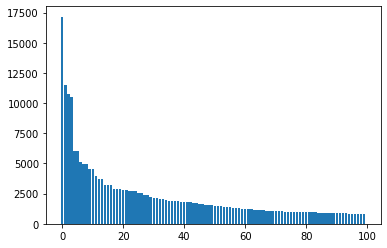

In [ ]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

In [ ]:
num_words_dict = 30000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

In [ ]:
# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}


# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word

In [ ]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

In [ ]:
x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)

In [ ]:
some_number = 1
print('Before converting: ', x_train_token[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['people', 'change', 'things', 'go', 'wrong', 'shit', 'happens', 'but', 'life', 'goes', 'on']
After converting:  [26, 91, 63, 72, 152, 322, 148, 11, 55, 609, 31]


In [ ]:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  2122
Mean tweet word length:  13.0
99% percent under:  2122.0


In [ ]:
# We choose the max length
max_length = 40

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, tweet in enumerate(sentences):
    len_tweet = len(tweet) 
    if len_tweet != 0:
      if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
        features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
      if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
        features[ii, :] = np.array(tweet)[-seq_len:]
  return features

In [ ]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [ ]:
some_number = 3
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [3, 85, 45, 114, 38]
After padding:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3
  85  45 114  38]


# Define dataloader and model

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 150

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last = True)

In [ ]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('x size: ', sample_x.size(), 'Y size', sample_y.size()) # batch_size, seq_length
# print('Sample input: \n', sample_x)
# print('Sample output: \n', sample_y)

x size:  torch.Size([150, 40]) Y size torch.Size([150])


In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.55):
        super(SentimentRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.no_layers = no_layers

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM Layers
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=no_layers, 
                            batch_first=True, 
                            dropout=drop_prob,
                            bidirectional=True
                            )
                                  

        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # Linear and Sigmoid layer
        # why not no_layers*hidden_dim? and for biLSTM x2?
        self.fc = nn.Linear(2*hidden_dim, output_dim)
#         self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Embedding out
        embeds = self.embedding(x)
        #Shape: [batch_size x max_length x embedding_dim]

        # LSTM out
        lstm_out, hidden = self.lstm(embeds, hidden)
        # Shape: [batch_size x max_length x hidden_dim]

        # Select the activation of the last Hidden Layer
        lstm_out = lstm_out[:,-1,:].contiguous()
        # Shape: [batch_size x hidden_dim]

         ## You can instead average the activations across all the times
        # lstm_out = torch.mean(lstm_out, 1).contiguous()

        # Dropout and Fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # Sigmoid function
#         sig_out = self.sig(out)

        # return last sigmoid output and hidden state
        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        #random initialization is better, i think 
        h0 = torch.randn((2*self.no_layers, batch_size, self.hidden_dim))
        c0 = torch.randn((2*self.no_layers, batch_size, self.hidden_dim))
        hidden = (h0, c0)
        return hidden


In [ ]:
# Let's define our model
model = SentimentRNN(no_layers=3,
                     vocab_size=num_words_dict, # 43800 dictionary
                     hidden_dim=64,
                     embedding_dim=32,
                     output_dim=LEN_CLASSES,    # 13 classes
                     drop_prob=0.55
                    )


# Moving to gpu

print(model)

SentimentRNN(
  (embedding): Embedding(30000, 32)
  (lstm): LSTM(32, 64, num_layers=3, batch_first=True, dropout=0.55, bidirectional=True)
  (dropout): Dropout(p=0.55, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  1209348


In [ ]:
# loss and optimization functions
lr = 0.01

criterion = nn.CrossEntropyLoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, labels):
    pred = torch.argmax(pred, dim=1)
#     labels = torch.argmax(labels, dim=1)
    return torch.sum((pred == labels).float())

In [ ]:
# Number of training Epochs
epochs = 15
# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()

  for inputs, labels in train_loader:
    # Initialize hidden state 
    h = model.init_hidden(batch_size)
    
    # Creating new variables for the hidden state
    h = tuple([each.data for each in h])
    
    # Move batch inputs and labels to gpu
    inputs, labels = inputs, labels   

    # Set gradient to zero
    model.zero_grad()
    
    # Compute model output
    output, h = model(inputs, h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.long())
    loss.backward()
    train_losses.append(loss.item())
    
    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
    
  for inputs, labels in test_loader:
    
    # Initialize hidden state 
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs, labels

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.long())

    val_losses.append(val_loss.item())

    accuracy = acc(output, labels)
    val_acc += accuracy

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(test_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

Epoch 1
train_loss : 1.3125848003796168 val_loss : 1.3184575239817302
train_accuracy : 36.81318664550781 val_accuracy : 35.100547790527344
Validation loss decreased (inf --> 1.318458).  Saving model ...
Epoch 2
train_loss : 1.1186773138386863 val_loss : 1.1859413782755535
train_accuracy : 49.03845977783203 val_accuracy : 40.58500671386719
Validation loss decreased (1.318458 --> 1.185941).  Saving model ...
Epoch 3
train_loss : 0.9712929129600525 val_loss : 1.2159357070922852
train_accuracy : 57.738094329833984 val_accuracy : 43.14442443847656
Epoch 4
train_loss : 0.807052378143583 val_loss : 1.1403917074203491
train_accuracy : 66.07142639160156 val_accuracy : 48.26325607299805
Validation loss decreased (1.185941 --> 1.140392).  Saving model ...
Epoch 5
train_loss : 0.6781445060457502 val_loss : 1.2930814822514851
train_accuracy : 73.16849517822266 val_accuracy : 45.886653900146484
Epoch 6
train_loss : 0.5482891414846692 val_loss : 1.1303312381108601
train_accuracy : 77.24359130859375 v

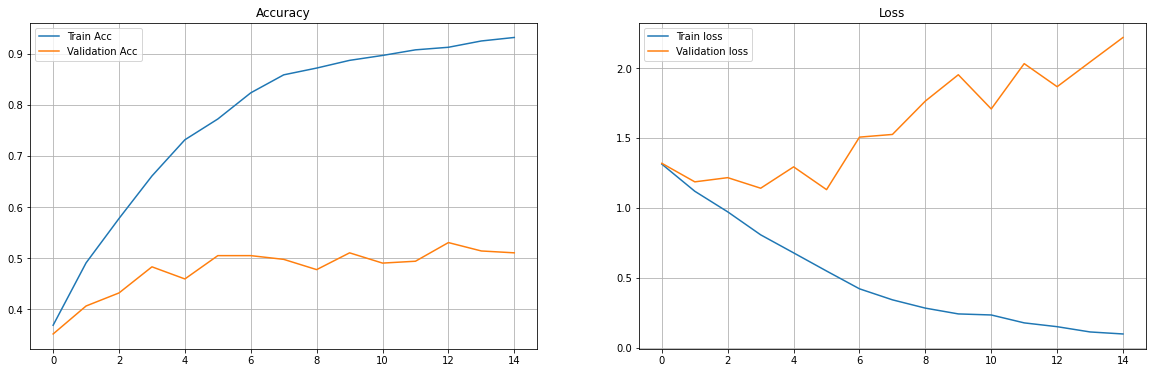

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()